In [1]:
import sys
sys.path.append('../')
from low_rank_rnns.modules import *
import matplotlib
from low_rank_rnns import mante, ranktwo, clustering, helpers, mante_regressions, rankone
from sklearn.mixture import GaussianMixture
import seaborn as sns
from scipy import stats

In [2]:
helpers.setup_matplotlib(release=True)
col_ctx1 = '#840045'
col_ctx2 = '#ae8844'
col_sig1 = '#d3dd16'
col_sig2 = '#faa72a'
col_stim_period = 'silver'
col_response_period = 'sandybrown'

In [3]:
def time_mapping(t):
    return t * mante.deltaT / 1000

In [4]:
hidden_size = 4096
noise_std = 5e-2
alpha = 0.2
x_train, y_train, mask_train, x_val, y_val, mask_val, epochs = \
    mante.generate_mante_data(1000, fraction_validation_trials=.2)
net = LowRankRNN(4, hidden_size, 1, noise_std, alpha, rank=1)
net.load_state_dict(torch.load(f'../models/mante_rank1_4096.pt', map_location='cpu'))

In [5]:
loss_orig, acc_orig = mante.test_mante(net, x_val, y_val, mask_val)
print(loss_orig)
print(acc_orig)

0.025998488068580627
1.0


In [6]:
m = net.m[:,0].detach().numpy()
n = net.n[:,0].detach().numpy()
wi1 = net.wi[0].detach().numpy()
wi2 = net.wi[1].detach().numpy()
wi_ctx1 = net.wi[2].detach().numpy()
wi_ctx2 = net.wi[3].detach().numpy()
wo = net.wo[:,0].detach().numpy()
vecs = clustering.make_vecs(net)

# Positivity adjustments
n = -n
m = -m

In [7]:
n_pops = 2
vecs = clustering.make_vecs(net)
z, model = clustering.gmm_fit(vecs, n_pops, algo='bayes', n_init=50, random_state=2020)

z = 1 - z   # inverting population labels for presentation purposes

In [8]:
colors = ['seagreen', 'rebeccapurple']

# Overlaps

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Use the colorbar set_ticks() method instead.


[Text(1, 0, '$-5$'), Text(1, 0, '$0$'), Text(1, 0, '$5$')]

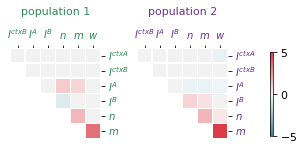

In [9]:
labels = ['$I^{ctxA}$', '$I^{ctxB}$','$I^A$', '$I^B$', '$n$', '$m$', '$w$']
lsize = 10

vecs = [wi_ctx1[z==0], wi_ctx2[z==0], wi1[z==0], wi2[z==0], n[z==0], m[z==0], wo[z==0]]
ov_pop1 = helpers.overlap_matrix(vecs)
vecs = [wi_ctx1[z==1], wi_ctx2[z==1], wi1[z==1], wi2[z==1], n[z==1], m[z==1], wo[z==1]]
ov_pop2 = helpers.overlap_matrix(vecs)
bound_pop1 = np.max((np.abs(np.min(ov_pop1)),np.abs(np.max(ov_pop1))))
bound_pop2 = np.max((np.abs(np.min(ov_pop2)),np.abs(np.max(ov_pop2))))
overall_bound = np.max((bound_pop1,bound_pop2))

fig, ax = plt.subplots(1, 2, figsize=(0.65 * 6, 0.65 * 3))
helpers.get_lower_tri_heatmap(ov_pop1, bounds=[-overall_bound, overall_bound], ax=ax[0])
ax[0].set_xticklabels(labels[1:], color='seagreen')
ax[0].set_yticks(np.array(list(range(len(labels) - 1))) + .5)
ax[0].set_yticklabels(labels[:-1], color='seagreen')
ax[0].xaxis.set_tick_params(labelsize=lsize)
ax[0].yaxis.set_tick_params(rotation=0, labelsize=lsize)
ax[0].set_title('population 1', color='seagreen', pad=12)

helpers.get_lower_tri_heatmap(ov_pop2, bounds=[-overall_bound, overall_bound], ax=ax[1])
ax[1].set_xticklabels(labels[1:], color='rebeccapurple')
ax[1].set_yticks(np.array(list(range(len(labels) - 1))) + .5)
ax[1].set_yticklabels(labels[:-1], color='rebeccapurple')
ax[1].xaxis.set_tick_params(labelsize=lsize)
ax[1].yaxis.set_tick_params(rotation=0, labelsize=lsize)
ax[1].set_title('population 2', color='rebeccapurple', pad=12)

fig.subplots_adjust(wspace=.4)
w = .01
h = .6
ax_cbar = fig.add_axes((1.05, .5 - h/2, w, h))
cmap = sns.diverging_palette(220, 10, sep=10, as_cmap=True)
matplotlib.colorbar.ColorbarBase(ax_cbar, cmap=cmap, orientation='vertical')
dec = 5 / (overall_bound * 2)
ax_cbar.set_yticks([.5 - dec, .5, .5 + dec])
ax_cbar.set_yticklabels([f'${-overall_bound:.0f}$', '$0$', f'${overall_bound:.0f}$'])
#plt.savefig('figures/4_mante_overlaps.pdf', bbox_inches='tight')

# Resampling

In [10]:
# Resample a few networks
losses_normal = []
accs_normal = []

n_samples = 10
net2 = clustering.to_support_net(net, np.zeros(hidden_size))
#train(net2, x_train, y_train, mask_train, 50, lr=1e-4, resample=True)
#net2.load_state_dict(torch.load('../models/mante_retrained_1pop.pt'))
for _ in range(n_samples):
    net2.resample_basis()
    loss, acc = mante.test_mante(net2, x_val, y_val, mask_val)
    losses_normal.append(loss)
    accs_normal.append(acc)

losses2 = []
accs2 = []
net3 = clustering.to_support_net(net, z)
#train(net3, x_train, y_train, mask_train, 50, lr=1e-4, resample=True)
net3.load_state_dict(torch.load('../models/mante_retrained_2pop.pt'))
for _ in range(n_samples):
    net3.resample_basis()
    loss, acc = mante.test_mante(net3, x_val, y_val, mask_val)
    losses2.append(loss)
    accs2.append(acc)
    
net_rec = SupportLowRankRNN_withMask(4, 1024, 1, noise_std, alpha, rank=1, n_supports=3, gaussian_basis_dim=5)
net_rec.load_state_dict(torch.load('../models/mante_rank1_reconstructed_1024.pt'))
accs_rec = []
for _ in range(n_samples):
    net_rec.resample_basis()
    loss, acc = mante.test_mante(net_rec, x_val, y_val, mask_val)
    accs_rec.append(acc)


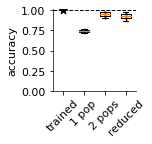

In [11]:
helpers.boxplot_accuracies([acc_orig, accs_normal, accs2, accs_rec], labels=['trained', '1 pop', '2 pops', 'reduced'],
                          figsize=(1.5, 1.5))
#plt.savefig('figures/4_mante_resampling.pdf', bbox_inches='tight')

Text(0.4, 0.5, 'Ctx B')

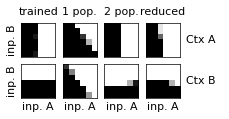

In [12]:
fig, ax = plt.subplots(2, 5, figsize=(0.6 * 6, 0.6 * 2.3))

mante.psychometric_matrices(net, axes=[ax[0][0], ax[1][0]])
mante.psychometric_matrices(net2, axes=[ax[0][1], ax[1][1]])
mante.psychometric_matrices(net3, axes=[ax[0][2], ax[1][2]])
mante.psychometric_matrices(net_rec, axes=[ax[0][3], ax[1][3]])

ax[0][0].set_title('trained')
ax[0][0].set_ylabel('inp. B')
ax[0][1].set_title('1 pop.')
ax[0][2].set_title('2 pop.')
ax[0][3].set_title('reduced')
ax[1][0].set_ylabel('inp. B')
for i in range(4):
    ax[1][i].set_xlabel('inp. A')

ax[0][4].set_axis_off()
ax[1][4].set_axis_off()
ax[0][4].text(.4, .5, 'Ctx A', va='center', ha='center')
ax[1][4].text(.4, .5, 'Ctx B', va='center', ha='center')

#plt.savefig('figures/4_mante_psycho.pdf', bbox_inches='tight')

# Traces

In [13]:
 def plot_inputs(x, col):
    ax[0][col].plot(time, x[:, 0], c=col_sig1)
    ax[0][col].plot(time, [coh1 * mante.SCALE] * len(time), ls='--', c=col_sig1)
    ax[0][col].axvline(time_mapping(ctx_beg), color='k', ls='--', alpha=.4)
    ax[0][col].axvspan(time_mapping(stim_beg), time_mapping(stim_end), color=col_stim_period, alpha=alpha_periods)
    ax[0][col].axvspan(time_mapping(response_beg), time_mapping(response_end), color=col_response_period, alpha=alpha_periods)
    ax[0][col].set(xlim=(0, time_mapping(x1.shape[0])), xticks=[], yticks=[], ylim=(-.4, .4))
    ax[0][col].spines['top'].set_visible(False)
    ax[0][col].spines['right'].set_visible(False)
    ax[0][col].spines['bottom'].set_position('zero')

    ax[1][col].plot(time, x[:, 1], c=col_sig2)
    ax[1][col].plot(time, [coh2 * mante.SCALE] * len(time), ls='--', c=col_sig2)
    ax[1][col].axvline(time_mapping(ctx_beg), color='k', ls='--', alpha=.4)
    ax[1][col].axvspan(time_mapping(stim_beg), time_mapping(stim_end), color=col_stim_period, alpha=alpha_periods)
    ax[1][col].axvspan(time_mapping(response_beg), time_mapping(response_end), color=col_response_period, alpha=alpha_periods)
    ax[1][col].set(xlim=(0, time_mapping(x1.shape[0])), xticks=[], yticks=[], ylim=(-.6, .6))
    ax[1][col].spines['top'].set_visible(False)
    ax[1][col].spines['right'].set_visible(False)
    ax[1][col].spines['bottom'].set_position('zero')

    ax[2][col].plot(time, x[:, 2], c=col_ctx1, zorder=30)
    ax[2][col].axvspan(time_mapping(stim_beg), time_mapping(stim_end), color=col_stim_period, alpha=alpha_periods)
    ax[2][col].axvline(time_mapping(ctx_beg), color='k', ls='--', alpha=.4)
    ax[2][col].axvspan(time_mapping(response_beg), time_mapping(response_end), color=col_response_period, alpha=alpha_periods)
    ax[2][col].set(xlim=(0, time_mapping(x1.shape[0])), ylim=(-.1, 1.1), xticks=[], yticks=[])
    ax[2][col].spines['top'].set_visible(False)
    ax[2][col].spines['right'].set_visible(False)
    ax[2][col].spines['bottom'].set_position('zero')

    ax[3][col].plot(time, x[:, 3], c=col_ctx2, zorder=30)
    ax[3][col].axvline(time_mapping(ctx_beg), color='k', ls='--', alpha=.4)
    ax[3][col].axvspan(time_mapping(stim_beg), time_mapping(stim_end), color=col_stim_period, alpha=alpha_periods)
    ax[3][col].axvspan(time_mapping(response_beg), time_mapping(response_end), color=col_response_period, alpha=alpha_periods)
    ax[3][col].set(xlim=(0, time_mapping(x1.shape[0])), ylim=(-.1, 1.1), xticks=[], yticks=[])
    ax[3][col].spines['top'].set_visible(False)
    ax[3][col].spines['right'].set_visible(False)
    ax[3][col].spines['bottom'].set_position('zero')

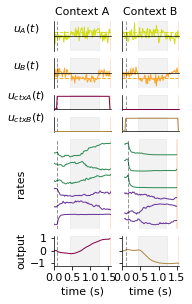

In [14]:
neurons1 = np.random.choice(np.where(z==0)[0], 3)
neurons2 = np.random.choice(np.where(z==1)[0], 3)
neurons = np.concatenate([neurons2, neurons1])
net.noise_std = noise_std
coh1 = 1
coh2 = -2
alpha_periods = .2
plot_width = 6

fig, ax = plt.subplots(6, 2, figsize=(.75 * 3, .75 * 6), gridspec_kw={'height_ratios': [1, 1, .5, .5, 3, 1]})

# Generate trajectories
x1, _, _, epochs = mante.generate_mante_data(1, coh_color_spec=coh1, coh_motion_spec=coh2, context_spec=1)
outp1, trajectories1 = net.forward(x1, return_dynamics=True)
trajectories1 = trajectories1.detach().numpy().squeeze()
rates1 = np.tanh(trajectories1)
x1 = x1.squeeze().numpy()
y1 = outp1.squeeze().detach().numpy()

x2, _, _, _ = mante.generate_mante_data(1, coh_color_spec=coh1, coh_motion_spec=coh2, context_spec=2)
outp2, trajectories2 = net.forward(x2, return_dynamics=True)
trajectories2 = trajectories2.detach().numpy().squeeze()
rates2 = np.tanh(trajectories2)
x2 = x2.squeeze().numpy()
y2 = outp2.squeeze().detach().numpy()

task_length = x1.shape[0]
time = time_mapping(np.arange(task_length))
ctx_beg = epochs[1][0]
stim_beg = epochs[2][0]
stim_end = epochs[2][1]
response_beg = epochs[4][0]
response_end = epochs[4][1]

plot_inputs(x1, 0)
ax[0][0].set_ylabel('$u_A(t)$', rotation='horizontal')
ax[1][0].set_ylabel('$u_B(t)$', rotation='horizontal')
ax[2][0].set_ylabel('$u_{ctxA}(t)$', rotation='horizontal')
ax[3][0].set_ylabel('$u_{ctxB}(t)$', rotation='horizontal')
plot_inputs(x2, 1)
for i in range(4):
    ax[i][1].set_yticks([])

colors_traces =  3*['rebeccapurple'] + 3*['seagreen']
helpers.plot_rates_single_neurons(rates1[:, neurons], offset=.4, colors=colors_traces, deltaT=mante.deltaT, 
                                  ax=ax[4][0])
ax[4][0].axvline(time_mapping(ctx_beg), color='k', ls='--', alpha=.4)
ax[4][0].axvspan(time_mapping(stim_beg), time_mapping(stim_end), color=col_stim_period, alpha=alpha_periods)
ax[4][0].axvspan(time_mapping(response_beg), time_mapping(response_end), color=col_response_period, alpha=alpha_periods)
ax[4][0].set(xlim=(0, time_mapping(x1.shape[0])))
ax[4][0].set(ylabel='rates', xticks=[], yticks=[])
ax[4][0].spines['bottom'].set_visible(False)
ax[4][0].spines['top'].set_visible(False)
ax[4][0].spines['right'].set_visible(False)
ax[4][0].spines['left'].set_visible(False)


colors_traces =  3*['rebeccapurple'] + 3*['seagreen']
helpers.plot_rates_single_neurons(rates2[:, neurons], offset=.4, colors=colors_traces, deltaT=mante.deltaT, 
                                  ax=ax[4][1])
ax[4][1].axvline(time_mapping(ctx_beg), color='k', ls='--', alpha=.4)
ax[4][1].axvspan(time_mapping(stim_beg), time_mapping(stim_end), color=col_stim_period, alpha=alpha_periods)
ax[4][1].axvspan(time_mapping(response_beg), time_mapping(response_end), color=col_response_period, alpha=alpha_periods)
ax[4][1].set(xticks=[], yticks=[])
ax[4][1].spines['bottom'].set_visible(False)
ax[4][1].spines['top'].set_visible(False)
ax[4][1].spines['right'].set_visible(False)
ax[4][1].spines['left'].set_visible(False)

ax[5][0].plot(time_mapping(np.arange(len(y1))), y1, c=col_ctx1)
ax[5][0].axvline(time_mapping(ctx_beg), color='k', ls='--', alpha=.4)
ax[5][0].axvspan(time_mapping(stim_beg), time_mapping(stim_end), color=col_stim_period, alpha=alpha_periods)
ax[5][0].axvspan(time_mapping(response_beg), time_mapping(response_end), color=col_response_period, alpha=alpha_periods)
ax[5][0].spines['top'].set_visible(False)
ax[5][0].spines['right'].set_visible(False)
ax[5][0].set(xlim=(0, time_mapping(x1.shape[0])), ylim=(-1.2, 1.2), xticks=[0, .5, 1, 1.5],
            xlabel='time (s)', ylabel='output')

ax[5][1].plot(time_mapping(np.arange(len(y1))), y2, c=col_ctx2)
ax[5][1].axvline(time_mapping(ctx_beg), color='k', ls='--', alpha=.4)
ax[5][1].axvspan(time_mapping(stim_beg), time_mapping(stim_end), color=col_stim_period, alpha=alpha_periods)
ax[5][1].axvspan(time_mapping(response_beg), time_mapping(response_end), color=col_response_period, alpha=alpha_periods)
ax[5][1].spines['top'].set_visible(False)
ax[5][1].spines['right'].set_visible(False)
ax[5][1].set(xlim=(0, time_mapping(x1.shape[0])), ylim=(-1.2, 1.2), xticks=[0, .5, 1, 1.5], yticklabels=['']*3,
             xlabel='time (s)')

ax[0][0].set_title('Context A')
ax[0][1].set_title('Context B')
fig.align_ylabels()
#plt.savefig('figures/4_mante_traces.pdf', bbox_inches='tight')

# Dynamics

In [15]:
# Next coming traces are noise-free
net.noise_std = 0.

coh1 = 1
coh2 = -2
x1, _, _, epochs = mante.generate_mante_data(1, std=0., coh_color_spec=coh1, coh_motion_spec=coh2, context_spec=1)
outp1, trajectories1 = net.forward(x1, return_dynamics=True)
trajectories1 = trajectories1.detach().numpy().squeeze()
rates1 = np.tanh(trajectories1)
x1 = x1.squeeze().numpy()

x2, _, _, _ = mante.generate_mante_data(1, std=0., coh_color_spec=coh1, coh_motion_spec=coh2, context_spec=2)
outp2, trajectories2 = net.forward(x2, return_dynamics=True)
trajectories2 = trajectories2.detach().numpy().squeeze()
rates2 = np.tanh(trajectories2)
x2 = x2.squeeze().numpy()

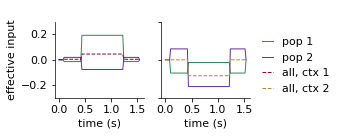

In [16]:
inp_integration1 = np.tanh(np.outer(x1[:, 0], wi1) + np.outer(x1[:, 1], wi2) + np.outer(x1[:, 2], wi_ctx1) + 
                         np.outer(x1[:, 3], wi_ctx2))
inp1_pop1 = inp_integration1[:, z==0] @ n[z==0].reshape((-1, 1)) / np.sum(1-z)
inp1_pop2 = inp_integration1[:, z==1] @ n[z==1].reshape((-1, 1)) / np.sum(z)
inp1_global = inp_integration1 @ n.reshape((-1, 1)) / net.hidden_size
inp_integration2 = np.tanh(np.outer(x2[:, 0], wi1) + np.outer(x2[:, 1], wi2) + np.outer(x2[:, 2], wi_ctx1) + 
                         np.outer(x2[:, 3], wi_ctx2))
inp2_pop1 = inp_integration2[:, z==0] @ n[z==0].reshape((-1, 1)) / np.sum(1-z)
inp2_pop2 = inp_integration2[:, z==1] @ n[z==1].reshape((-1, 1)) / np.sum(z)
inp2_global = inp_integration2 @ n.reshape((-1, 1)) / net.hidden_size
time = time_mapping(np.arange(x1.shape[0]))

fig, ax = plt.subplots(1, 2, figsize=(.7 * 5, .7 * 2))
pl1, = ax[0].plot(time, inp1_pop1, c=colors[0])
pl2, = ax[0].plot(time, inp1_pop2, c=colors[1])
pl3, = ax[0].plot(time, inp1_global, ls='--', c=col_ctx1)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set(xticks=[0, .5, 1, 1.5], ylim=(-.3, .3), xlabel='time (s)', ylabel='effective input')

ax[1].plot(time, inp2_pop1, c=colors[0])
ax[1].plot(time, inp2_pop2, c=colors[1])
pl4, = ax[1].plot(time, inp2_global, ls='--', c=col_ctx2)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set(xticks=[0, .5, 1, 1.5], ylim=(-.2, .2), yticklabels=['']*3, xlabel='time (s)')

fig.legend([pl1, pl2, pl3, pl4], ['pop 1', 'pop 2', 'all, ctx 1', 'all, ctx 2'], 
           bbox_to_anchor=(1., .7), handlelength=1, loc='center left')
#plt.savefig('figures/4_mante_kappainp.pdf', bbox_inches='tight')

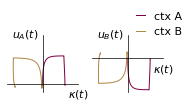

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(.8 * 3.5, .7 * 1.5))

I1_orth = wi1 - (wi1 @ m) * m / (m @ m)
I2_orth = wi2 - (wi2 @ m) * m / (m @ m)

projm1 = trajectories1 @ m / net.hidden_size 
proji1 = trajectories1 @ I1_orth / net.hidden_size
projm2 = trajectories2 @ m / net.hidden_size
proji2 = trajectories2 @ I1_orth / net.hidden_size

pl1, = ax[0].plot(projm1, proji1, c=col_ctx1)
pl2, = ax[0].plot(projm2, proji2, c=col_ctx2)
helpers.center_axes(ax[0])
ax[0].set(xticks=[], yticks=[], xlim=(-3, 3), ylim=(-0.03, 0.17))
ax[0].set_xlabel('$\kappa(t)$', x=1)
ax[0].set_ylabel('$u_A(t)$', y=.9, ha='right', rotation=0)

proji1 = trajectories1 @ I2_orth / net.hidden_size
proji2 = trajectories2 @ I2_orth / net.hidden_size
ax[1].plot(projm1, proji1, c=col_ctx1)
ax[1].plot(projm2, proji2, c=col_ctx2)
helpers.center_axes(ax[1])
ax[1].set(xticks=[], yticks=[], xlim=(-3, 3), ylim=(-0.22, 0.15))
ax[1].set_xlabel('$\kappa(t)$', x=1)
ax[1].set_ylabel('$u_B(t)$', y=.9, ha='right', rotation=0)

lgd = ax[1].legend([pl1, pl2], ['ctx A', 'ctx B'], bbox_to_anchor=(1.4, 1.6), handlelength=.8)

#plt.savefig('figures/4_mante_dynamics.pdf', bbox_inches='tight', bbox_extra_artists=(lgd,))

# Scatters

pop 0: slope=0.46, intercept=-0.03
pop 1: slope=-0.18, intercept=0.02
pop 0: slope=-0.28, intercept=-0.02
pop 1: slope=0.48, intercept=0.01


Text(0, 0.9, '$I_i^{B}$')

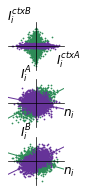

In [18]:
fig, ax = plt.subplots(3, 1, figsize=(1, 3))
fs = 12
clustering.pop_scatter_linreg(wi_ctx1, wi_ctx2, z, 2, colors=colors, linreg=False, ax=ax[0])
ax[0].set_xlabel('$I_i^{ctxA}$', horizontalalignment='right', x=1.3, fontsize=fs)
ax[0].set_ylabel('$I_i^{ctxB}$', horizontalalignment='right', y=.9, rotation='horizontal', fontsize=fs)
clustering.pop_scatter_linreg(n, wi1, z, 2, colors=colors, ax=ax[1])
ax[1].set_xlabel('$n_i$', horizontalalignment='right', x=1.2, fontsize=fs)
ax[1].set_ylabel('$I_i^{A}$', horizontalalignment='right', y=.9, rotation='horizontal', fontsize=fs)
clustering.pop_scatter_linreg(n, wi2, z, 2, colors=colors, ax=ax[2])
ax[2].set_xlabel('$n_i$', horizontalalignment='right', x=1.2, fontsize=fs)
ax[2].set_ylabel('$I_i^{B}$', horizontalalignment='right', y=.9, rotation='horizontal', fontsize=fs)
#plt.savefig('figures/4_mante_scatters.pdf', bbox_inches='tight')

# Violin plots

In [19]:
x1, _, _, _ = mante.generate_mante_data(1, coherences=[0.], std=0., context_spec=1)
outp, trajectories = net.forward(x1, return_dynamics=True)
trajectories = trajectories.detach().squeeze().numpy()
phi_primes1 = helpers.phi_prime(trajectories[mante.stim_begin:mante.stim_end].mean(axis=0))


In [20]:
x2, _, _, _ = mante.generate_mante_data(1, coherences=[0.], std=0., context_spec=2)
outp, trajectories = net.forward(x2, return_dynamics=True)
trajectories = trajectories.detach().squeeze().numpy()
phi_primes2 = helpers.phi_prime(trajectories[mante.stim_begin:mante.stim_end].mean(axis=0))

Text(0.5, 1.0, 'Context B')

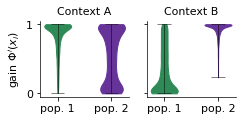

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(.7 * 5, .7 * 2))

pl = ax[0].violinplot([phi_primes1[z==i] for i in range(2)])
ax[0].set_yticks([0, 1])
ax[0].set_xticks([1, 2])
ax[0].set_xticklabels(['pop. 1', 'pop. 2'])
pl['bodies'][0].set_color(colors[0])
pl['bodies'][0].set_alpha(1)
pl['bodies'][1].set_color(colors[1])
pl['bodies'][1].set_alpha(1)
pl['cbars'].set_color('black')
pl['cbars'].set_linewidth(.5)
pl['cmins'].set_color('black')
pl['cmins'].set_linewidth(.5)
pl['cmaxes'].set_color('black')
pl['cmaxes'].set_linewidth(.5)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_ylabel('gain $\\Phi\'(x_i)$')
ax[0].set_title('Context A')

pl = ax[1].violinplot([phi_primes2[z==i] for i in range(2)])
ax[1].set_yticks([0, 1])
ax[1].set_yticklabels(['', ''])
ax[1].set_xticks([1, 2])
ax[1].set_xticklabels(['pop. 1', 'pop. 2'])
pl['bodies'][0].set_color(colors[0])
pl['bodies'][0].set_alpha(1)
pl['bodies'][1].set_color(colors[1])
pl['bodies'][1].set_alpha(1)
pl['cbars'].set_color('black')
pl['cbars'].set_linewidth(.5)
pl['cmins'].set_color('black')
pl['cmins'].set_linewidth(.5)
pl['cmaxes'].set_color('black')
pl['cmaxes'].set_linewidth(.5)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_title('Context B')

#plt.savefig('figures/4_mante_violin.pdf', bbox_inches='tight')